# Historical Stock/Revenue Data & Dashboard Project

## Question 1: Use yfinance to Extract Historical Stock Data for Tesla

In [229]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

In [230]:
tesla = yf.Ticker("TSLA")
tesla_info = tesla.info
tesla_data = tesla.history(period="max")

In [231]:
tesla_data.reset_index(inplace=True)
tesla_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


In [232]:
tesla_data.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
3709,2025-03-27 00:00:00-04:00,272.480011,291.850006,271.820007,273.130005,162572100,0.0,0.0
3710,2025-03-28 00:00:00-04:00,275.579987,276.100006,260.570007,263.549988,123809400,0.0,0.0
3711,2025-03-31 00:00:00-04:00,249.309998,260.559998,243.360001,259.160004,134008900,0.0,0.0
3712,2025-04-01 00:00:00-04:00,263.799988,277.450012,259.250000,268.459991,146486900,0.0,0.0
3713,2025-04-02 00:00:00-04:00,254.600006,284.989990,251.270004,282.760010,196325604,0.0,0.0


In [233]:
tesla_data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,3714.000000,3714.000000,3714.000000,3714.000000,3.714000e+03,3714.0,3714.000000
mean,85.733163,87.629662,83.686139,85.695857,9.671844e+07,0.0,0.002154
std,111.856077,114.375292,109.051807,111.739587,7.721740e+07,0.0,0.095668
min,1.076000,1.108667,0.998667,1.053333,1.777500e+06,0.0,0.000000
25%,12.285334,12.568167,12.070167,12.303833,4.959322e+07,0.0,0.000000
50%,18.507333,18.760334,18.224334,18.492666,8.244660e+07,0.0,0.000000
75%,185.027496,188.642502,180.675003,184.965000,1.223229e+08,0.0,0.000000
max,475.899994,488.540009,457.510010,479.859985,9.140820e+08,0.0,5.000000


Text(0.5, 1.0, 'Tesla Stock Close Price History')

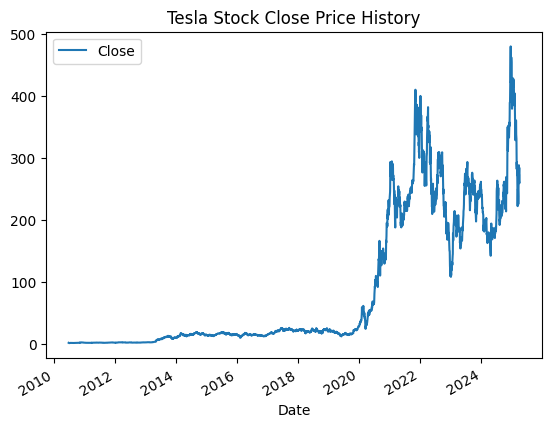

In [234]:
tesla_data.plot(x="Date", y="Close")
plt.title("Tesla Stock Close Price History")

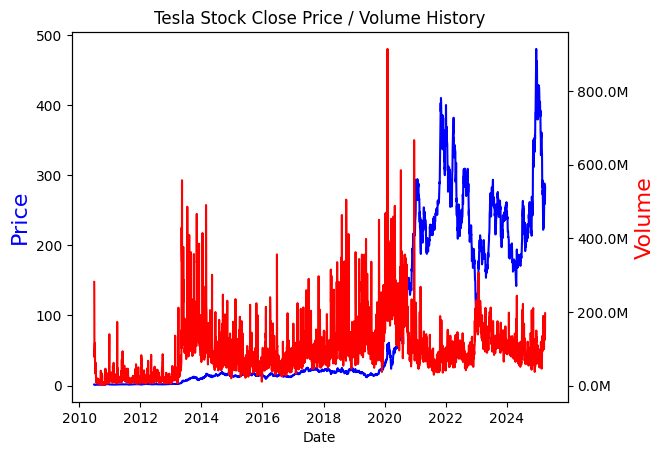

In [235]:
def volume_formatter(x, pos):
    return str(round(x / 1e6, 1)) + "M"

fig,ax=plt.subplots()
plt.title("Tesla Stock Close Price / Volume History")
ax.plot(tesla_data["Date"],tesla_data["Close"], color='blue')
ax.set_xlabel("Date")
ax.set_ylabel("Price", color='blue', fontsize=16)
ax2 = ax.twinx()
ax2.plot(tesla_data["Date"],tesla_data["Volume"], color='red')
ax2.set_ylabel('Volume', color='red', fontsize=16)
ax2.yaxis.get_major_formatter().set_scientific(False)
ax2.yaxis.set_major_formatter(volume_formatter)
plt.show()

## Questions 2-6 - Webscraping / DashBoard Functions 
### Utilized for Tesla and GameStop Data

In [236]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter

# Creating a function to retrieve Revenue data
def get_company_revenue(url, table_type="annual"):
    headers = {"User-Agent": "Mozilla/5.0"}  # Mimic a browser request
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print("Failed to retrieve data")
        return None
    
    soup = BeautifulSoup(response.text, 'html.parser')
    title = soup.title.string.split('|')[0].strip()
    company = title.split(' ')[0].strip()
    # print(title)
    # print(company)
    tables = soup.find_all("table", class_="historical_data_table table")
    
    if not tables or len(tables) < 2:
        print("Could not find sufficient revenue tables")
        return None
    
    revenue_table = tables[0] if table_type == "annual" else tables[1]
    
    rows = revenue_table.find_all('tr')
    data = []
    
    for row in rows[1:]:  # Skip header row
        cols = row.find_all('td')
        if len(cols) == 2:
            date = cols[0].text.strip()
            revenue = cols[1].text.strip()
            data.append([date, revenue[1:]])
    
    df = pd.DataFrame(data, columns=["Date", "Revenue"])
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by="Date", ascending=True)  # Ensure ascending order
    df["Revenue"] = df["Revenue"].replace(',', '', regex=True)  # Remove commas
    df["Revenue"] = pd.to_numeric(df["Revenue"], errors='coerce')  # Convert to numbers
    
    file_name = company + "_" + ("annual" if table_type == "annual" else "quarterly") + "_revenue.csv"
    df.to_csv(file_name, index=False)
    print()
    print(f"{company} {table_type} revenue data saved to {file_name}")
    print()
    print(f"{company}_revenue Last Five records using 'tail' function:")
    print(df.tail())
    return df, title

# Creating a function to plot Revenue data
def plot_revenue_dashboard(url, table_type="annual"):
    if table_type == "annual":
        annual_df, title = get_company_revenue(url, "annual")
        quarterly_df = None
        if annual_df is None:
            print("Could not generate dashboard due to missing data.")
            return
    elif table_type == "quarterly":
        annual_df=None
        quarterly_df, title = get_company_revenue(url, "quarterly")
        if quarterly_df is None:
            print("Could not generate dashboard due to missing data.")
            return
    else:
        print(f"Selected Revenue Table_Type Parameter '{table_type}' is invalid")
        return
    
    plt.figure(figsize=(12, 6))
    if table_type=="annual":
        plt.plot(annual_df["Date"], annual_df["Revenue"], marker="o", linestyle="-", label="Annual Revenue")
        # max_revenue = annual_df["Revenue"].max()
    elif table_type=="quarterly":
        plt.plot(quarterly_df["Date"], quarterly_df["Revenue"], marker="s", linestyle="-", label="Quarterly Revenue")
        # max_revenue = quarterly_df["Revenue"].max()
        # print(max_revenue)
    
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Revenue ($M)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    # plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=10))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
     
    plt.show()

def make_graph(ticker):
    stock = yf.Ticker(ticker)
    history = stock.history(period="max")

    history.reset_index(inplace=True)

    plt.figure(figsize=(12, 6))
    # history.plot(x="Date", y="Close")
    plt.plot(history["Date"], history["Close"], label="Closing Price", color="blue")
    plt.xlabel("Date")
    plt.ylabel("Price $")
    plt.title(f"{ticker} Stock Close Price")
    plt.legend()
    plt.grid(True)
    plt.show()


## Question 2 & 5 - Extract Tesla Revenue Data and Show Revenue Dashboard


Tesla annual revenue data saved to Tesla_annual_revenue.csv

Tesla_revenue Last Five records using 'tail' function:
        Date  Revenue
4 2020-01-01    31536
3 2021-01-01    53823
2 2022-01-01    81462
1 2023-01-01    96773
0 2024-01-01    97690


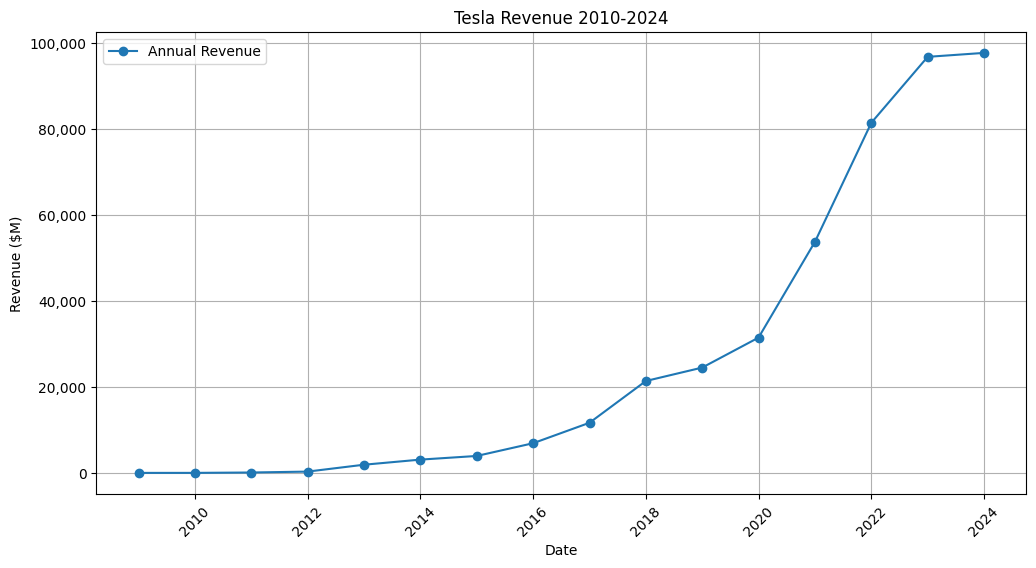

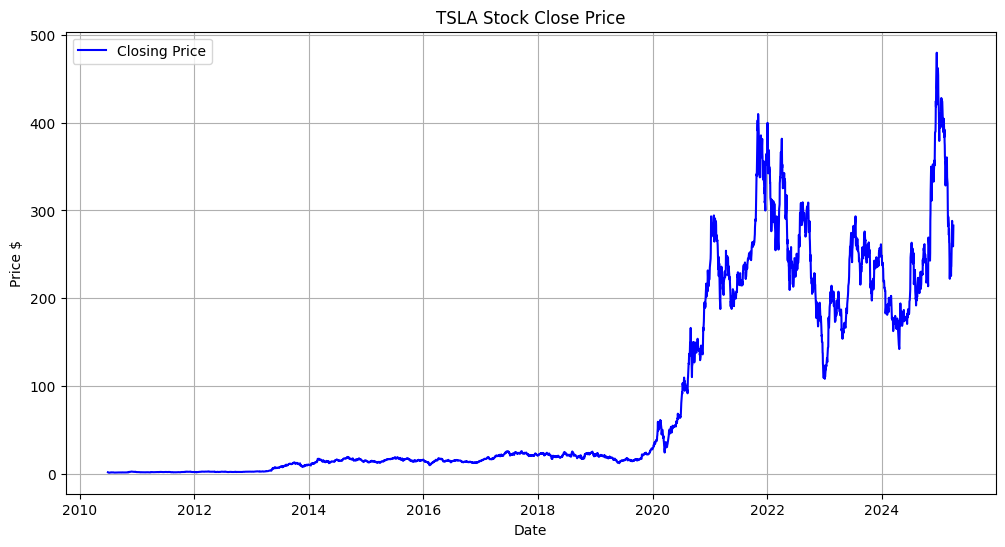

In [237]:
tesla_url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
# plot_revenue_dashboard(tesla_url, "quarterly")
plot_revenue_dashboard(tesla_url, "annual")
make_graph("TSLA")


## Question 3 - Extracting GameStop Stock Data Using yfinance

In [238]:
gamestop = yf.Ticker("GME")
gamestop_info = gamestop.info
gamestop_data = gamestop.history(period="max")
gamestop_data.reset_index(inplace=True)
gamestop_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-02-13 00:00:00-05:00,1.620129,1.693350,1.603296,1.691667,76216000,0.0,0.0
1,2002-02-14 00:00:00-05:00,1.712707,1.716074,1.670626,1.683250,11021600,0.0,0.0
2,2002-02-15 00:00:00-05:00,1.683250,1.687458,1.658001,1.674834,8389600,0.0,0.0
3,2002-02-19 00:00:00-05:00,1.666418,1.666418,1.578047,1.607504,7410400,0.0,0.0
4,2002-02-20 00:00:00-05:00,1.615920,1.662210,1.603296,1.662210,6892800,0.0,0.0


In [239]:
gamestop_data.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
5817,2025-03-27 00:00:00-04:00,25.870001,26.280001,21.160000,22.090000,96733100,0.0,0.0
5818,2025-03-28 00:00:00-04:00,21.889999,22.790001,21.700001,21.730000,44771700,0.0,0.0
5819,2025-03-31 00:00:00-04:00,21.400000,22.629999,20.730000,22.320000,16147900,0.0,0.0
5820,2025-04-01 00:00:00-04:00,22.760000,23.250000,21.950001,22.610001,14435300,0.0,0.0
5821,2025-04-02 00:00:00-04:00,22.490000,23.020000,22.250000,22.650000,9890191,0.0,0.0


Text(0.5, 1.0, 'GameStop Stock Close Price History')

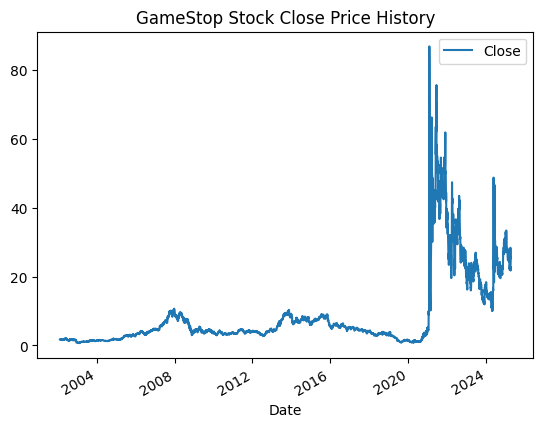

In [240]:
gamestop_data.plot(x="Date", y="Close")
plt.title("GameStop Stock Close Price History")

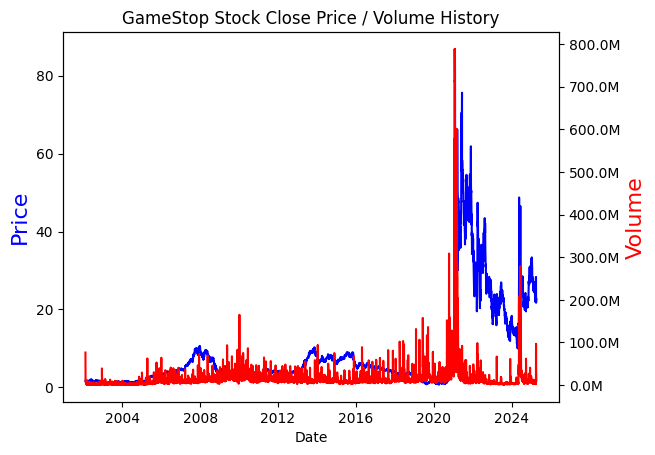

In [241]:
fig,ax=plt.subplots()
plt.title("GameStop Stock Close Price / Volume History")
ax.plot(gamestop_data["Date"],gamestop_data["Close"], color='blue')
ax.set_xlabel("Date")
ax.set_ylabel("Price", color='blue', fontsize=16)
ax2 = ax.twinx()
ax2.plot(gamestop_data["Date"],gamestop_data["Volume"], color='red')
ax2.set_ylabel('Volume', color='red', fontsize=16)
ax2.yaxis.get_major_formatter().set_scientific(False)
ax2.yaxis.set_major_formatter(volume_formatter)
plt.show()

## Question 4 & 6 - Extract GameStop Revenue Data and Show Revenue Dashboard


GameStop annual revenue data saved to GameStop_annual_revenue.csv

GameStop_revenue Last Five records using 'tail' function:
        Date  Revenue
4 2021-01-01     5090
3 2022-01-01     6011
2 2023-01-01     5927
1 2024-01-01     5273
0 2025-01-01     3823


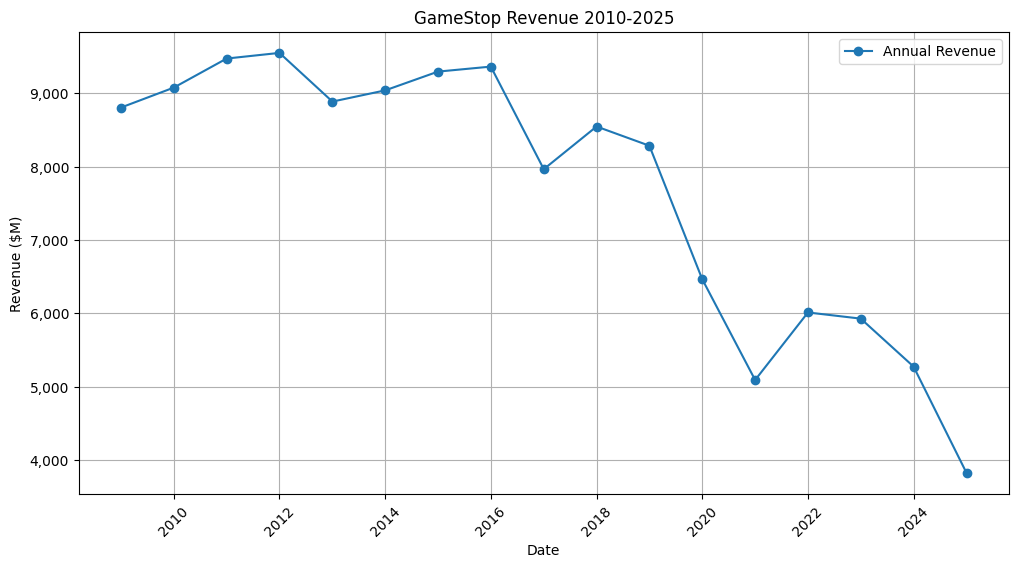

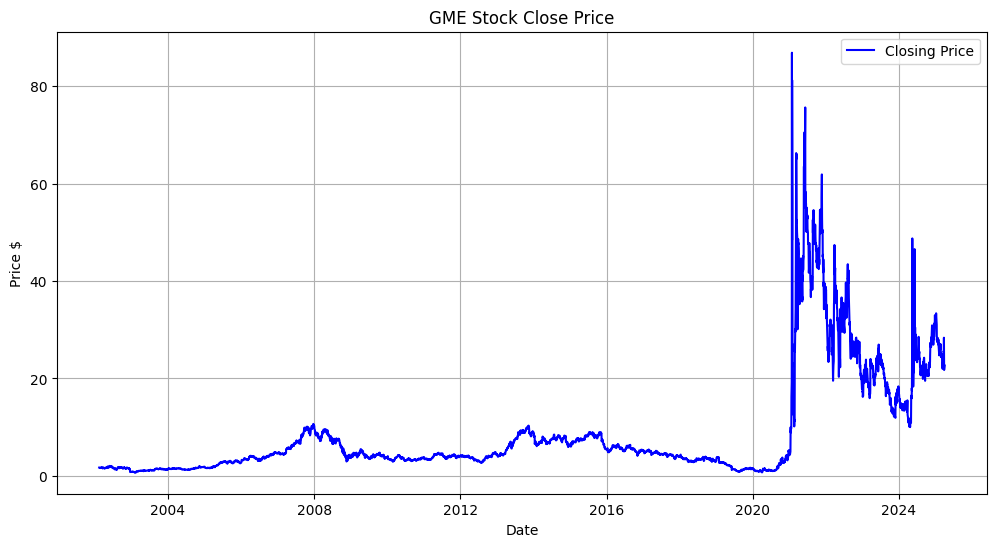

In [242]:
gamestop_url = "https://www.macrotrends.net/stocks/charts/GME/gamestop/revenue"
# plot_revenue_dashboard(gamestop_url, "quarterly")
plot_revenue_dashboard(gamestop_url, "annual")
make_graph("GME")